In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import AlgoLoop
import StatisticFunc

plt.style.use('Solarize_Light2')                     # 绘图风格
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 字体雅黑
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False    # 处理负号

# 预处理

## 提取并处理数据

### 权益类资产换手率

In [2]:
Turnovers = pd.read_excel(io="Raw/国内资产换手率.xlsx")                      # 读取数据
Turnovers = Turnovers.drop([0], axis=0)                                   # 删除多余行
Turnovers["日期"] = pd.DatetimeIndex(Turnovers["日期"])                    # 类型转换
Turnovers = Turnovers.set_index("日期")                                   # 设置索引

In [3]:
Turnovers = Turnovers.drop(Turnovers.index[0], axis=0)                   # 日期对齐

### GC007利率

In [4]:
Rates = pd.read_excel(io="Raw/GC007利率.xlsx")           #  读取数据
Rates = Rates.drop([0, 1, 2], axis=0)                   # 删除多余行
Rates.columns = ['日期', 'GC007']                        # 修改列名
Rates["日期"] = pd.DatetimeIndex(Rates["日期"])           # 类型转换
Rates = Rates.set_index("日期")                          # 设置索引

In [5]:
Rates = Rates.drop(Rates.index[0], axis=0)                     # 日期对齐

### 十年国债收益率

In [6]:
BondRates = pd.read_excel(io="Raw/中债国债到期收益率(中债)(日).xls")        # 读取数据
BondRates.columns = ['日期', '十年国债收益率']                             # 修改列名
BondRates = BondRates.drop([0, 3870, 3871], axis=0)                     # 删除多余行
BondRates["日期"] = pd.DatetimeIndex(BondRates["日期"])                   # 类型转换
BondRates = BondRates.set_index("日期")                                  # 设置索引

### 各资产收盘价

In [7]:
Assets = pd.read_excel(io="Raw/国内资产收盘价.xlsx")
Assets = Assets.drop([0], axis=0)                                   # 删除多余行
Assets["日期"] = pd.DatetimeIndex(Assets["日期"])                    # 类型转换
Assets = Assets.set_index("日期")                                   # 设置索引

### 十年国债价格指数

In [8]:
Data = Assets.merge(BondRates, how='left', left_index=True, right_index=True)

In [9]:
Data = Data.merge(Rates, how='left', left_index=True, right_index=True)

In [10]:
Data['持有时长'] = (Data.index - Data.index[0]).days
Data['10年国债价格指数'] = 100 - (Data['十年国债收益率'] - 3.0) * 8.2 + 3.0 * Data['持有时长'] / 365.0
Data['10年国债价格指数'] = Data['10年国债价格指数'].fillna(method='ffill')

## 计算各资产收益率

### 日内损益

In [11]:
# 利用自制10年国债价格指数，替换上证10年国债
Assets['上证10年国债'] = Data['10年国债价格指数'].values

In [12]:
Returns = Assets.pct_change(axis=0)
Returns = Returns.dropna(axis=0, how='all')           # 删除无数据日

In [58]:
drop_lst = ['中信证券COMEX铜期货', '中信证券WTI原油期货', '中信证券铁矿石']
Returns = Returns.drop(drop_lst, axis=1)

Returns.head()

,沪深300,中证500,上证10年国债,信用债3-5AAA,中信证券COMEX黄金期货
日期,,,,,
2008-01-03,0.006858,0.020846,0.001023,-0.001605,0.007522
2008-01-04,0.011364,0.002348,0.002414,0.000392,-0.003857
2008-01-07,0.013302,0.019983,0.000881,0.000171,-0.005423
2008-01-08,-0.005136,-0.027535,-0.000611,-0.001376,0.022578
2008-01-09,0.015503,0.029983,0.000111,-0.000422,0.000652


### 累计损益

In [59]:
cumReturns = (1.0 + Returns)
cumReturns = cumReturns.fillna(1.0)                    # 填充空值
cumReturns = cumReturns.cumprod()                      # 计算各资产累计收益率

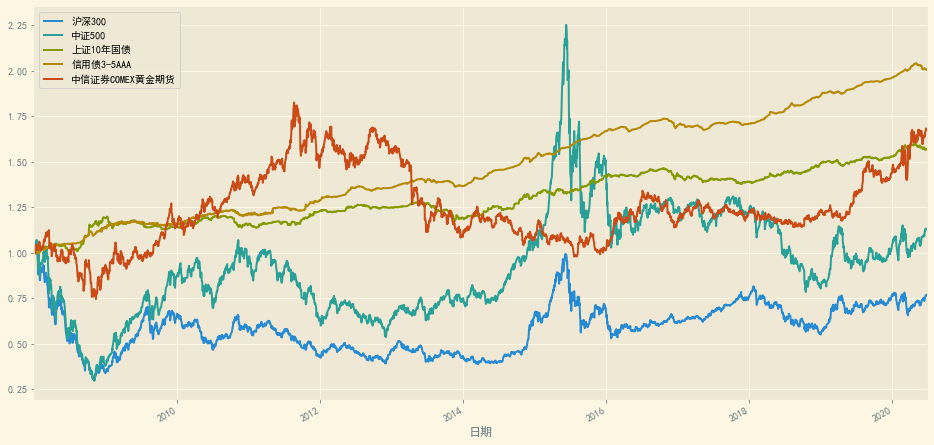

In [60]:
cumReturns.plot(figsize=(16, 8))

### 杠杆调整后的债券净值

In [61]:
lever = 2.0                                 # 杠杆
leverReturns = Returns.copy()               # 创建副本 
leverCumReturns = cumReturns.copy()   

# 更新杠杆调整后的债券净值
leverReturns.loc[:, ['上证10年国债', '信用债3-5AAA']] = Returns.loc[:, ['上证10年国债', '信用债3-5AAA']] * (1.0 + lever) - Rates.values * lever / (365.0 * 100)

# 更新累计净值
leverCumReturns = (1.0 + leverReturns)
leverCumReturns = leverCumReturns.fillna(1.0)                    # 填充空值
leverCumReturns = leverCumReturns.cumprod()                      # 计算各资产累计收益率

# 风险平价 + 杠杆策略（指数权重EMA）

## 程序运行

In [75]:
tradeDF_base, weightDF_base = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema')

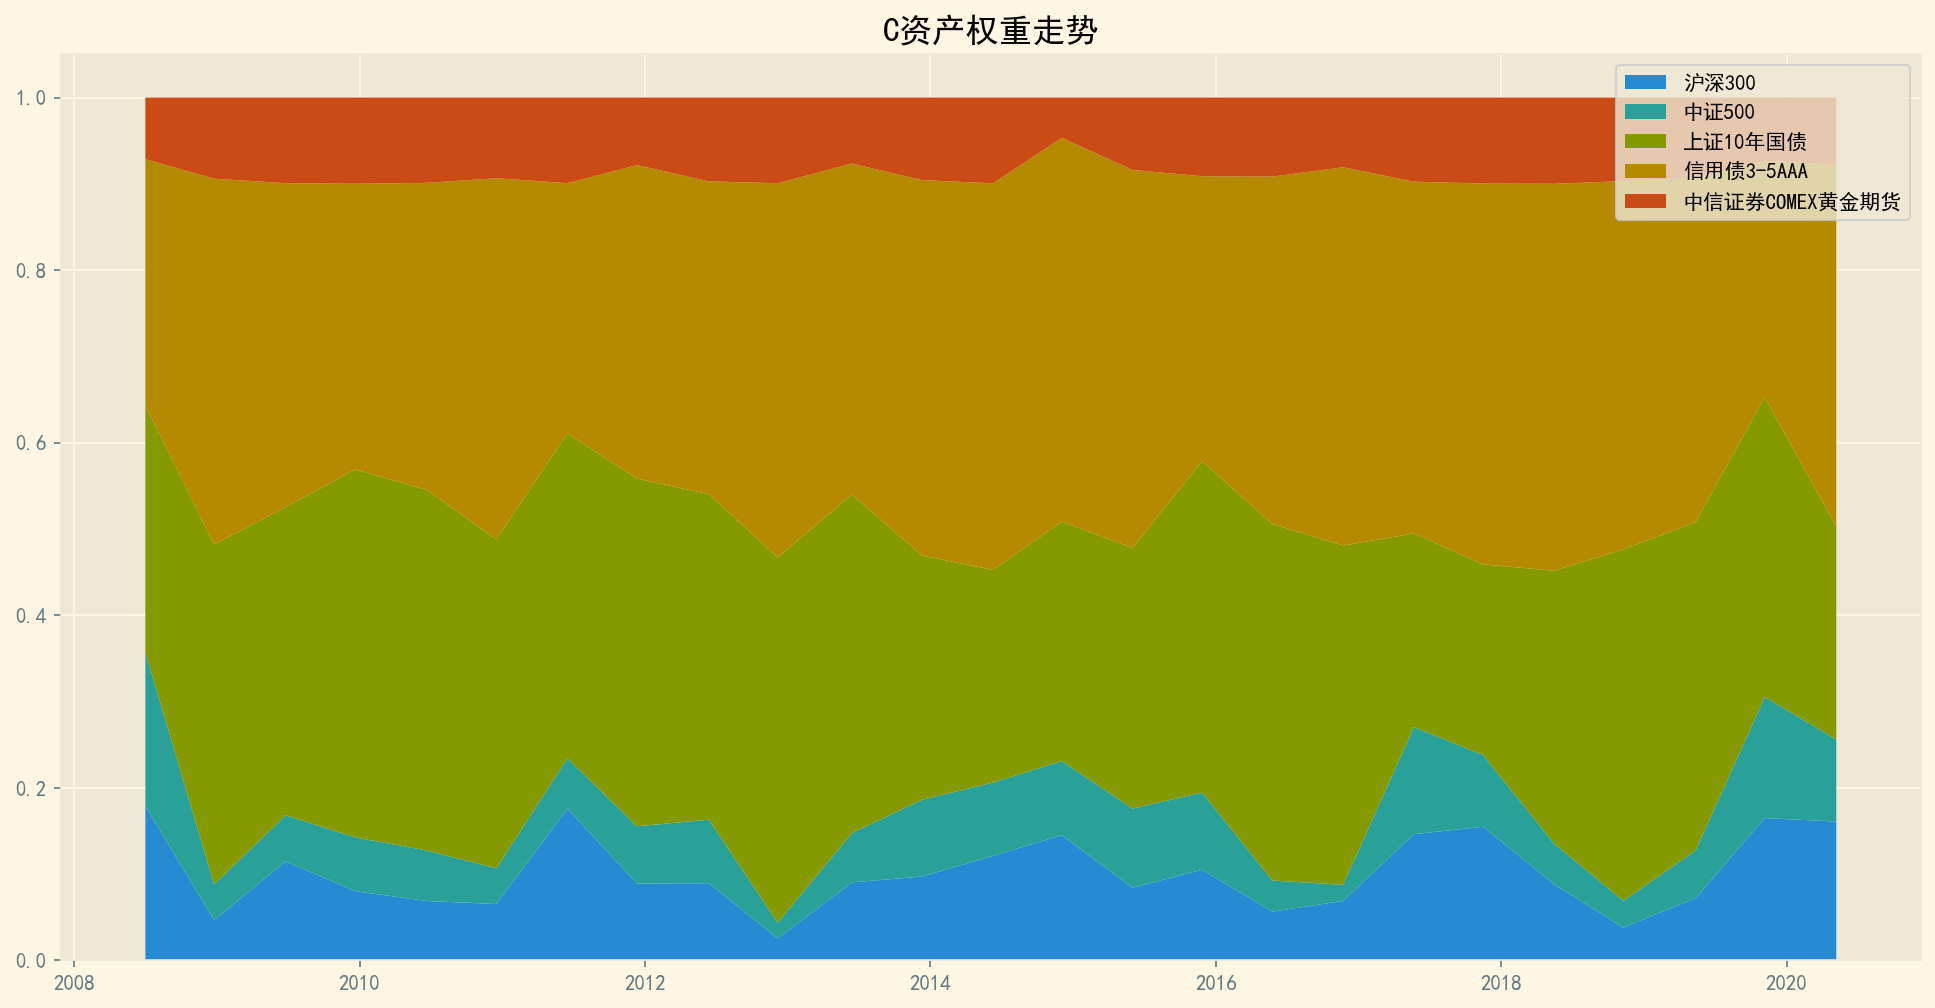

In [76]:
StatisticFunc.WeightPlot(tradeDF_base, weightDF_base, 'C')

## 回测表现汇总

In [77]:
# 表现汇总
years = np.unique(tradeDF_base.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_base = pd.DataFrame(index=years)

SummaryDF_base["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_base['投资组合净值']) )
SummaryDF_base["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_base['投资组合净值'])).values
SummaryDF_base["无基准夏普比率"] = SummaryDF_base['年收益率'] / SummaryDF_base['年波动率']
SummaryDF_base["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_base['最大回撤'])).values

SummaryDF_base

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.13793,0.166788,0.82698,-0.102252
2009,0.0772438,0.088209,0.87569,-0.055322
2010,0.0651322,0.065995,0.986924,-0.074621
2011,0.0609593,0.076574,0.796085,-0.092296
2012,0.0400632,0.045682,0.877011,-0.051217
2013,-0.101698,0.064012,-1.58874,-0.150015
2014,0.309572,0.057557,5.37853,-0.153919
2015,0.295588,0.080070,3.69159,-0.056592
2016,-0.016362,0.058284,-0.280728,-0.100884
2017,-0.0244241,0.040621,-0.601267,-0.126906


## 收益率贡献度

In [78]:
annualContrb_base = StatisticFunc.AnnualContribution(tradeDF=tradeDF_base, weightDF=weightDF_base, assetDF=leverCumReturns)

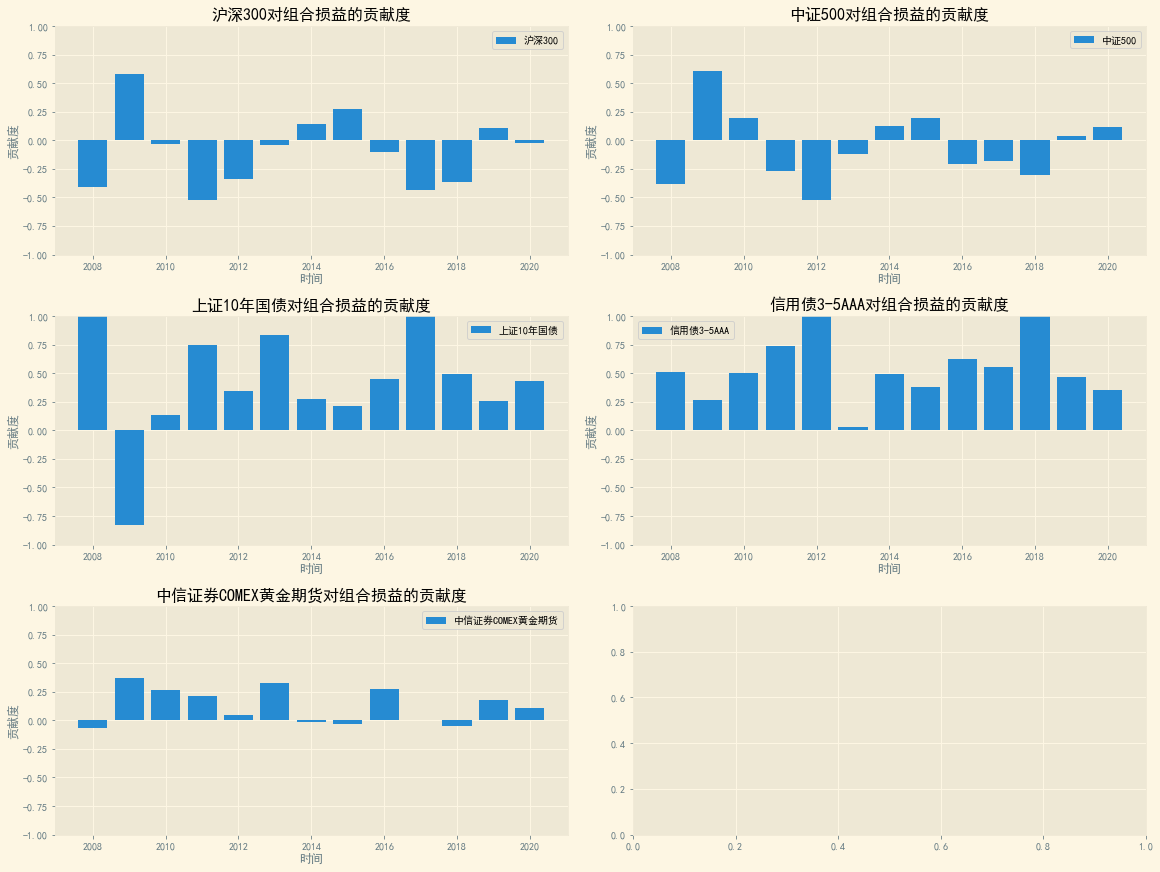

In [79]:
StatisticFunc.BarPlot(annualContrb_base, 'C')

## 投资组合净值曲线

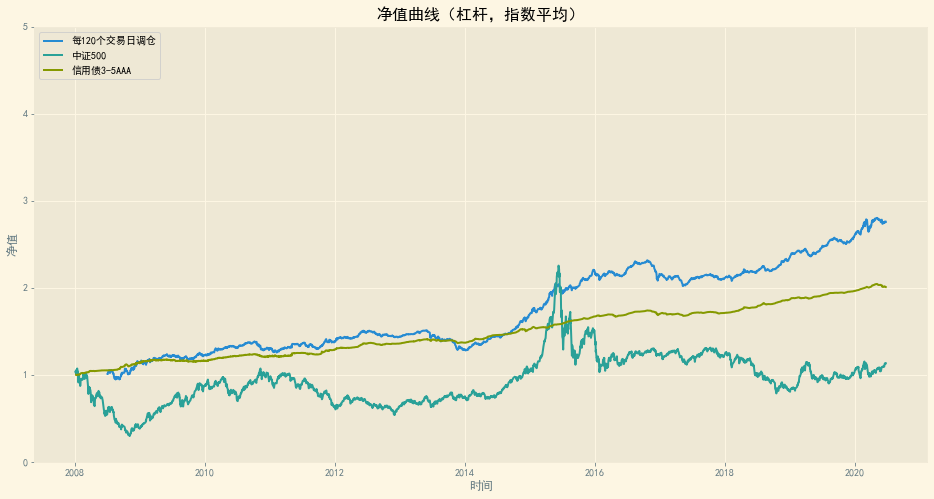

In [80]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_base.index, tradeDF_base['投资组合净值']/10000, label='每120个交易日调仓')
    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均）')
plt.savefig('净值曲线（杠杆，指数平均）C.png')

# 基准组合（多因子）

## 程序运行

In [81]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 
            'copperGold':False, 'copperGas':True}

tradeDF, weightDF = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

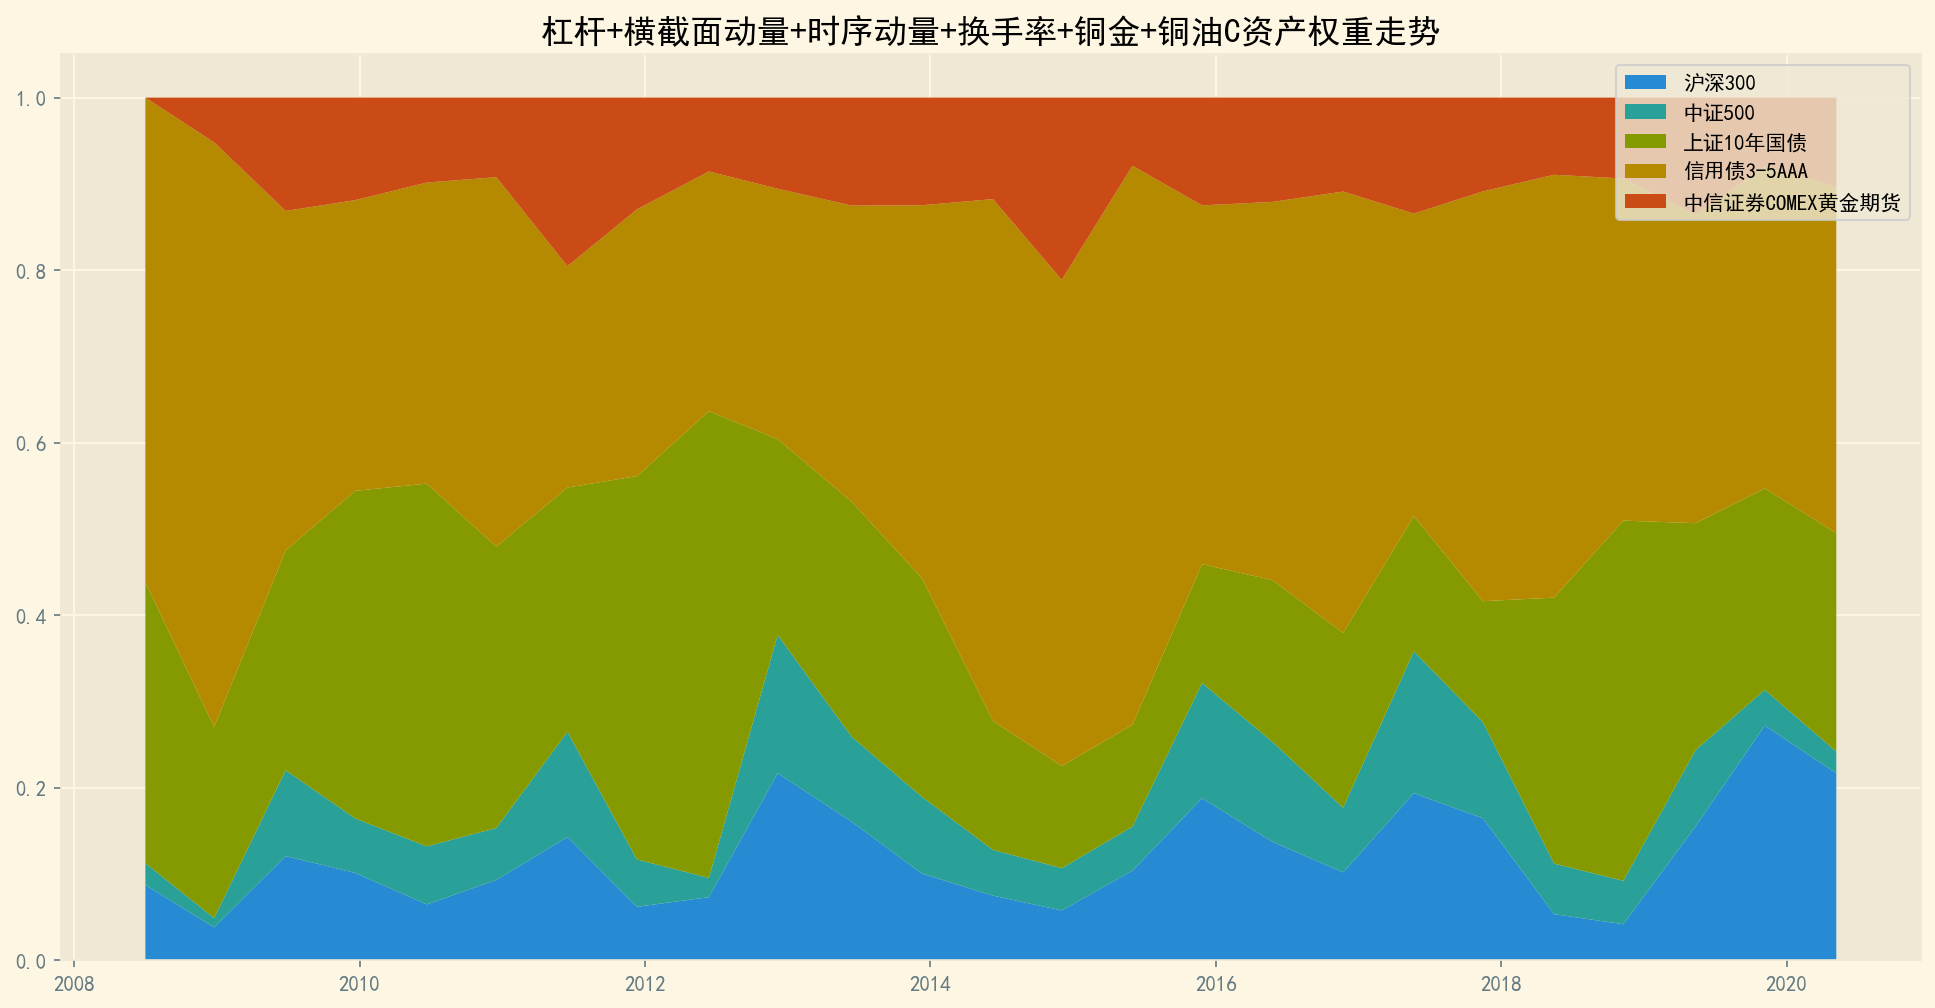

In [82]:
StatisticFunc.WeightPlot(tradeDF, weightDF, '杠杆+横截面动量+时序动量+换手率+铜金+铜油C')

## 回测表现汇总

In [83]:
# 表现汇总
years = np.unique(tradeDF.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF = pd.DataFrame(index=years)

SummaryDF["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF['投资组合净值']) )
SummaryDF["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF['投资组合净值'])).values
SummaryDF["无基准夏普比率"] = SummaryDF['年收益率'] / SummaryDF['年波动率']
SummaryDF["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF['最大回撤'])).values

SummaryDF

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.315666,0.133751,2.3601,-0.042926
2009,0.0996825,0.101610,0.981026,-0.056586
2010,0.0597548,0.066919,0.892946,-0.073706
2011,0.044213,0.081895,0.539878,-0.091918
2012,0.0939921,0.051078,1.84015,-0.046226
2013,-0.0937589,0.090384,-1.03733,-0.151006
2014,0.25435,0.048674,5.22563,-0.154589
2015,0.224289,0.061444,3.65027,-0.042347
2016,-0.0222882,0.075993,-0.293294,-0.085397
2017,0.00411433,0.042904,0.0958955,-0.106381


## 收益率贡献度

In [84]:
annualContrb = StatisticFunc.AnnualContribution(tradeDF=tradeDF, weightDF=weightDF, assetDF=leverCumReturns)

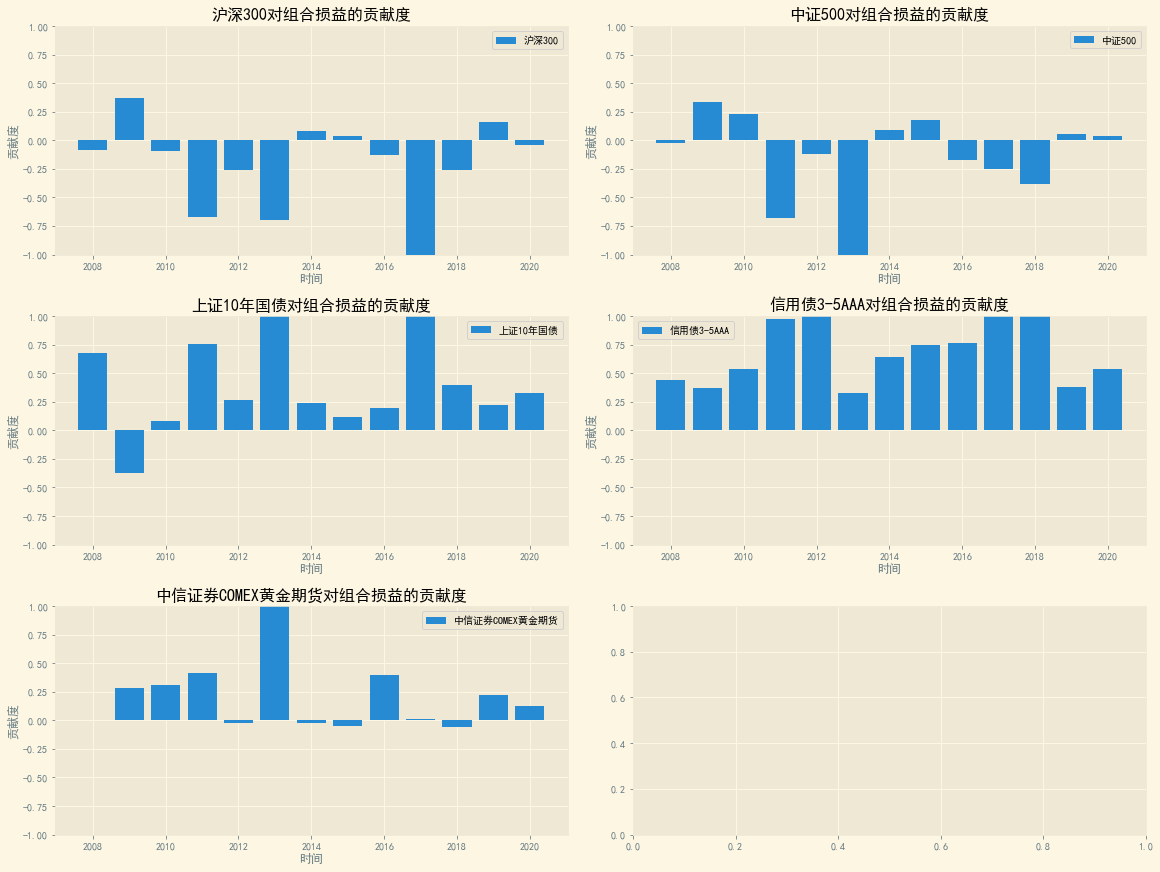

In [85]:
StatisticFunc.BarPlot(annualContrb, '横截面动量+时序动量+换手率+铜金+铜油C')

## 投资组合净值曲线

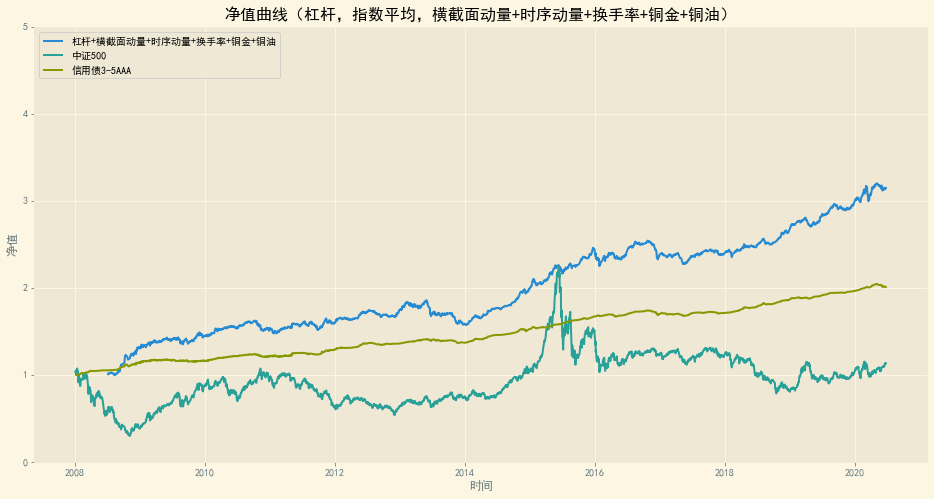

In [86]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, label='杠杆+横截面动量+时序动量+换手率+铜金+铜油')
    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜金+铜油）C.png')

# 风险平价 + 杠杆 + 多因子策略（指数平均）

## 时序动量+换手率+铜金+铜油

### 程序运行

In [22]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':True}

tradeDF_1, weightDF_1 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

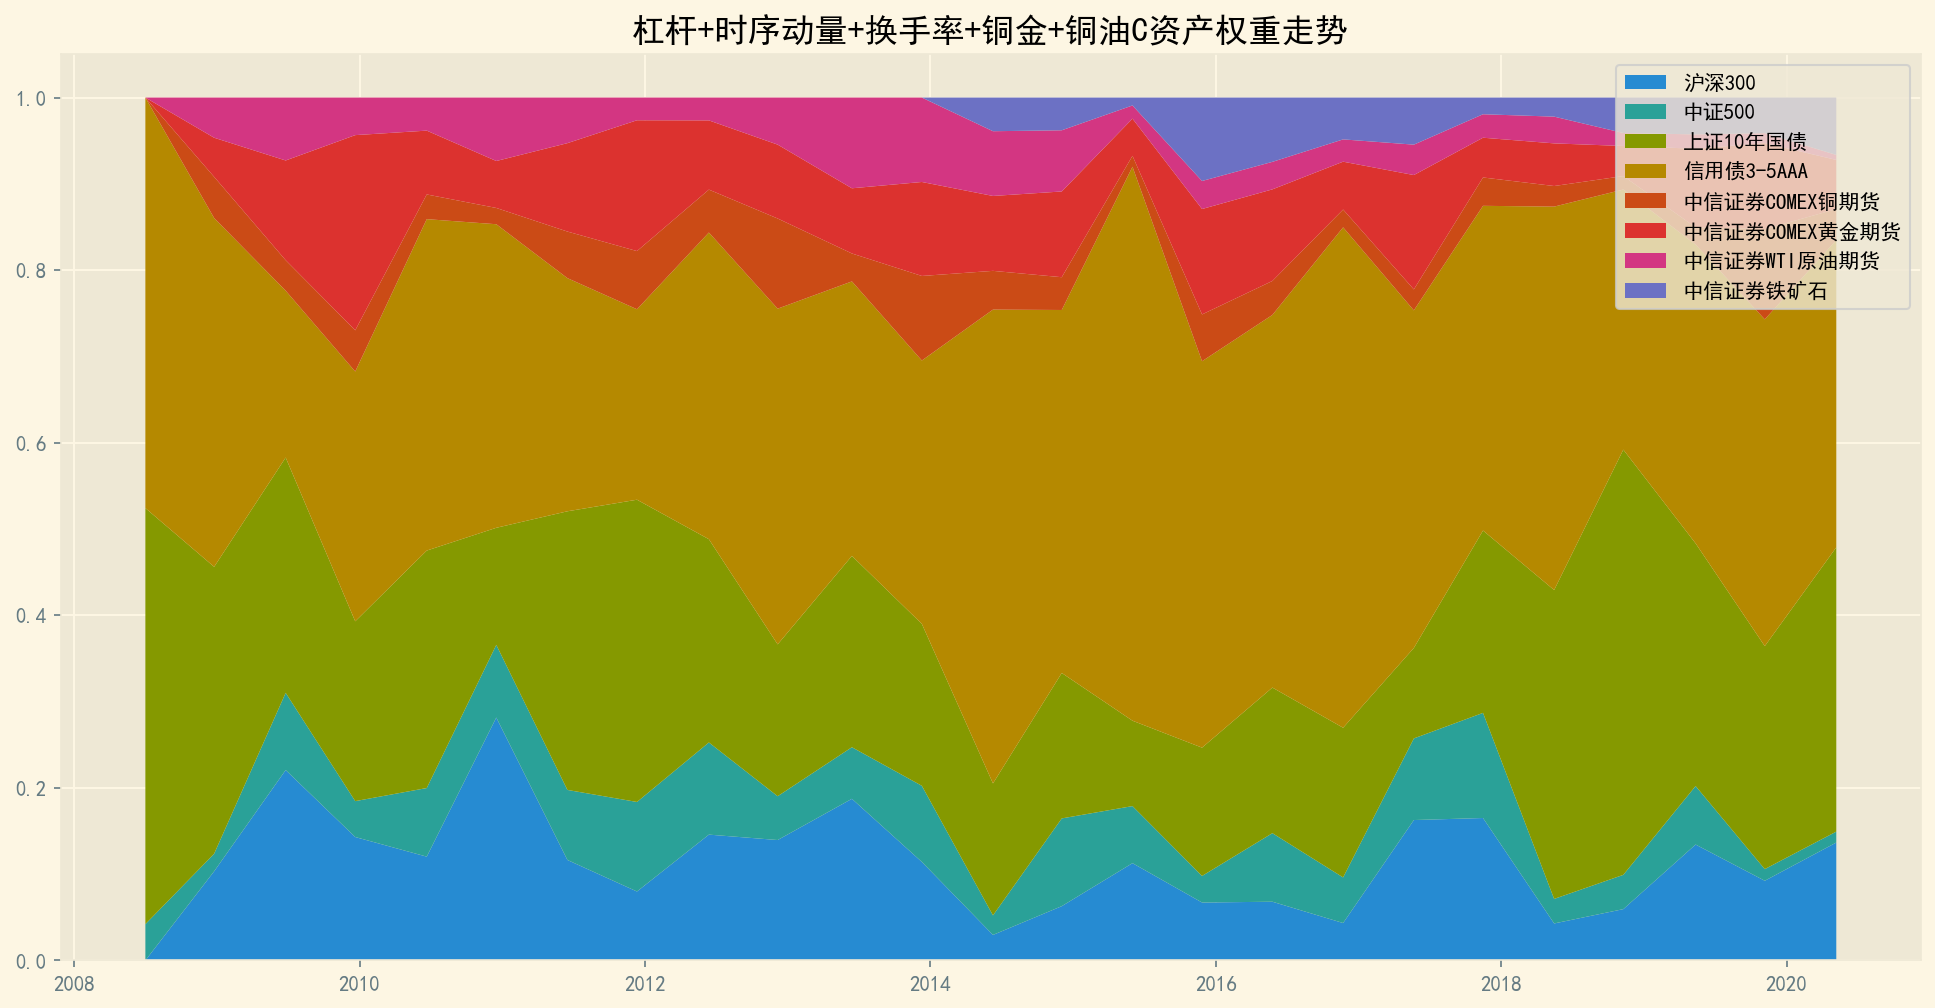

In [29]:
StatisticFunc.WeightPlot(tradeDF_1, weightDF_1, '杠杆+时序动量+换手率+铜金+铜油C')

### 回测表现汇总

In [30]:
# 表现汇总
years = np.unique(tradeDF_1.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_1 = pd.DataFrame(index=years)

SummaryDF_1["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_1['投资组合净值']) )
SummaryDF_1["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_1['投资组合净值'])).values
SummaryDF_1["无基准夏普比率"] = SummaryDF_1['年收益率'] / SummaryDF_1['年波动率']
SummaryDF_1["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_1['最大回撤'])).values

SummaryDF_1

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.428982,0.147783,2.90278,-0.032915
2009,0.189788,0.122516,1.54909,-0.086001
2010,0.0617059,0.081443,0.757656,-0.061438
2011,0.00661215,0.090190,0.0733137,-0.093252
2012,0.0331536,0.061686,0.537455,-0.061502
2013,-0.0843137,0.075014,-1.12397,-0.124411
2014,0.13216,0.049627,2.6631,-0.131931
2015,0.240397,0.072531,3.31439,-0.052586
2016,0.101071,0.061297,1.64888,-0.077316
2017,-0.00430164,0.042303,-0.101687,-0.111917


### 收益率贡献度

In [23]:
annualContrb_1 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_1, weightDF=weightDF_1, assetDF=leverCumReturns)

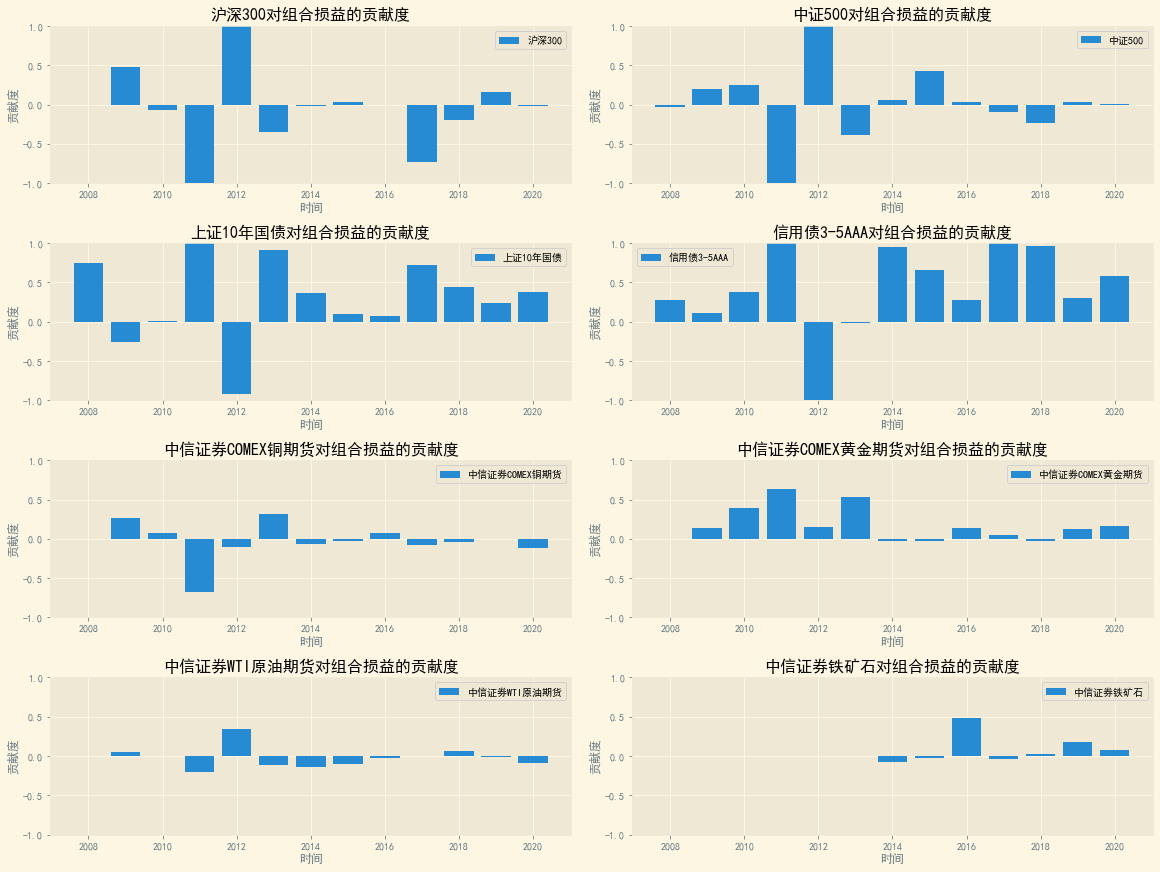

In [24]:
StatisticFunc.BarPlot(annualContrb_1, '时序动量+换手率+铜金+铜油C')

### 投资组合净值曲线

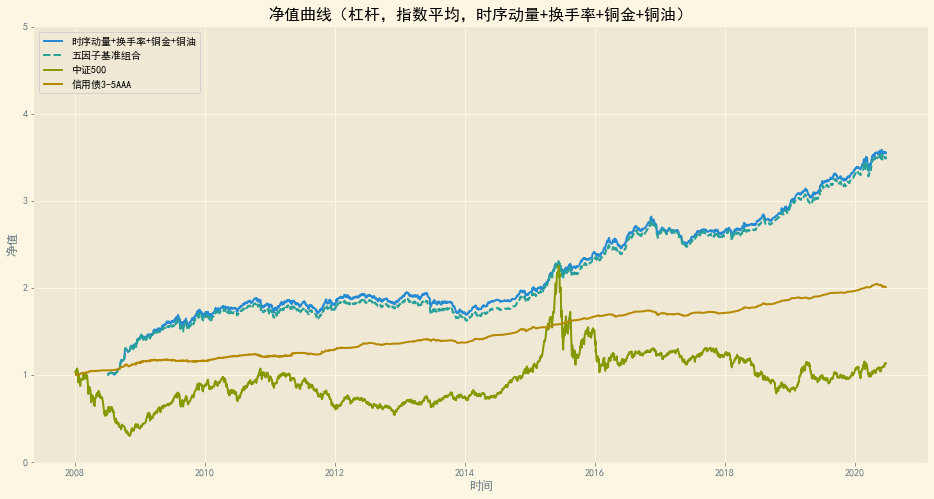

In [33]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_1.index, tradeDF_1['投资组合净值']/10000, label='时序动量+换手率+铜金+铜油')

# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，时序动量+换手率+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，时序动量+换手率+铜金+铜油）C.png')

## 横截面动量+换手率+铜金+铜油

### 程序运行

In [25]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':True}

tradeDF_2, weightDF_2 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

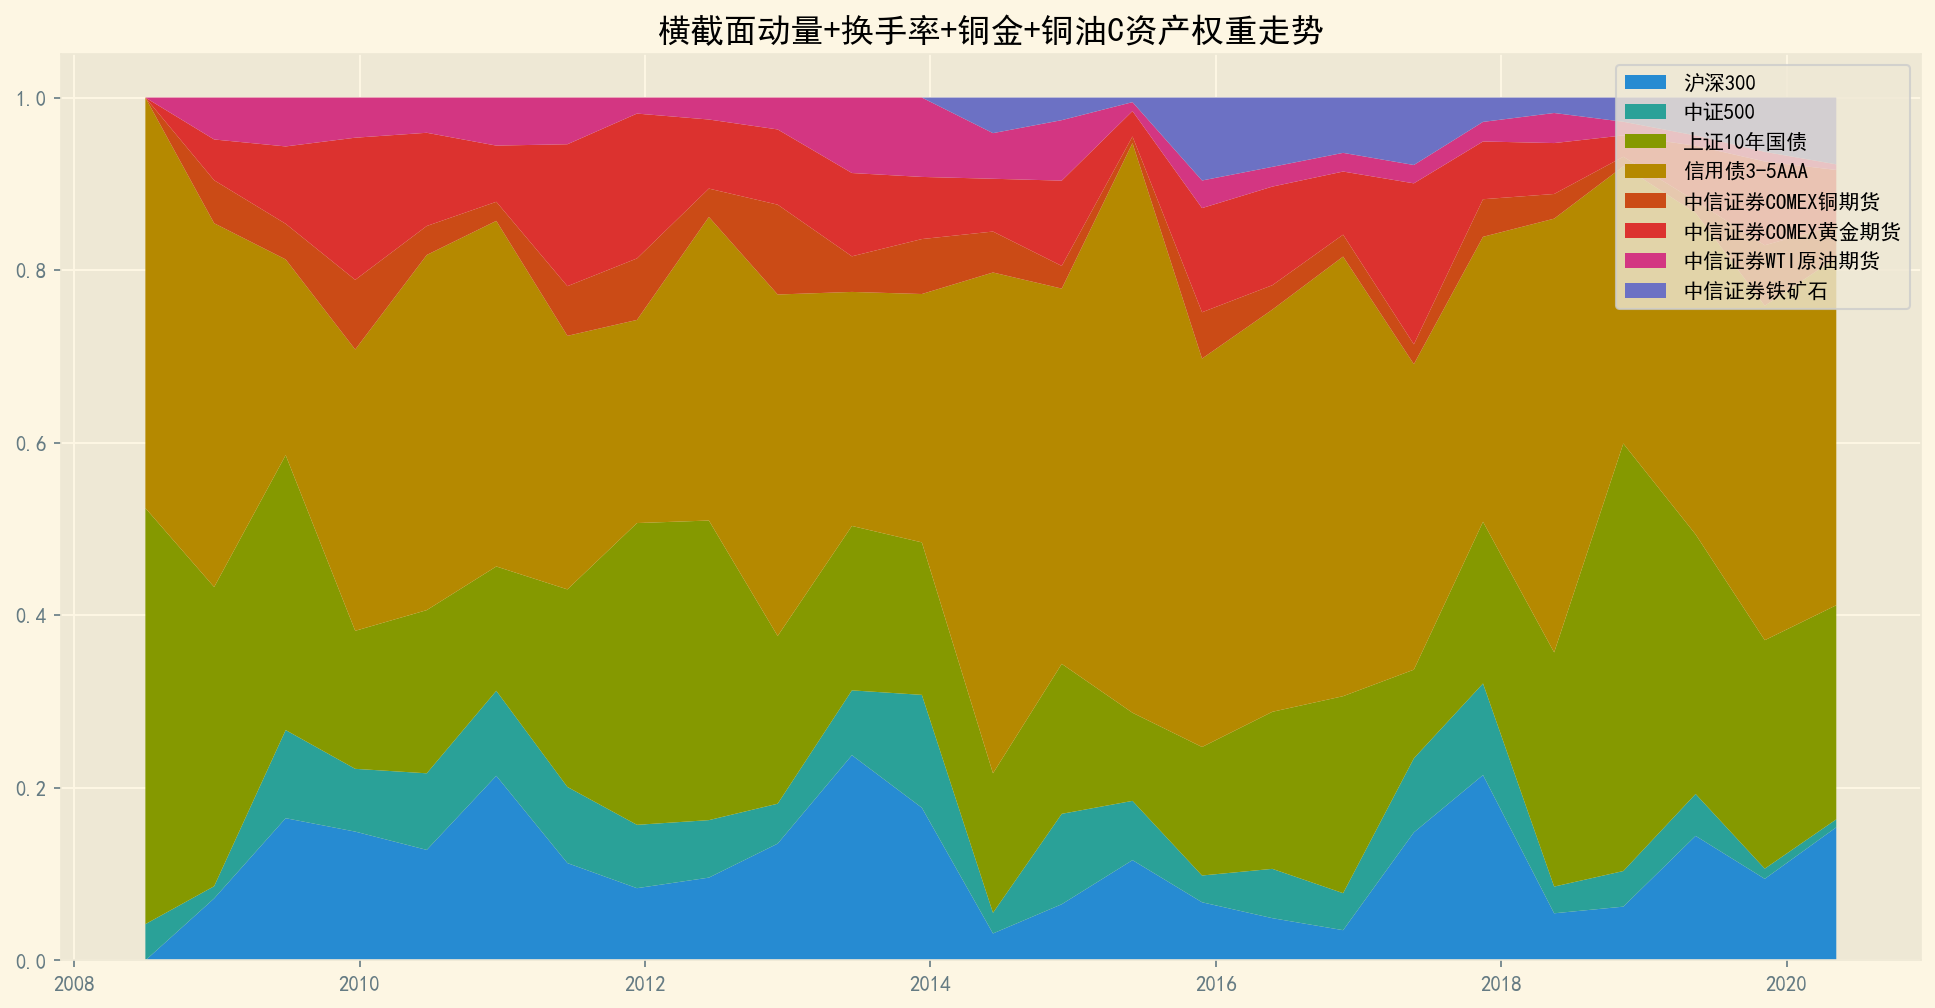

In [35]:
StatisticFunc.WeightPlot(tradeDF_2, weightDF_2, '横截面动量+换手率+铜金+铜油C')

### 回测表现汇总

In [36]:
# 表现汇总
years = np.unique(tradeDF_2.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_2 = pd.DataFrame(index=years)

SummaryDF_2["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_2['投资组合净值']) )
SummaryDF_2["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_2['投资组合净值'])).values
SummaryDF_2["无基准夏普比率"] = SummaryDF_2['年收益率'] / SummaryDF_2['年波动率']
SummaryDF_2["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_2['最大回撤'])).values

SummaryDF_2

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.431852,0.148003,2.91786,-0.032915
2009,0.159373,0.112527,1.4163,-0.071656
2010,0.0607062,0.087739,0.691892,-0.058589
2011,0.00809241,0.090777,0.089146,-0.083919
2012,0.045423,0.054708,0.830279,-0.048406
2013,-0.0766409,0.080283,-0.954634,-0.117034
2014,0.137913,0.054300,2.53981,-0.129149
2015,0.254854,0.073296,3.47703,-0.052956
2016,0.102909,0.061378,1.67664,-0.079591
2017,-0.00939044,0.046818,-0.200573,-0.114863


### 收益率贡献度

In [26]:
annualContrb_2 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_2, weightDF=weightDF_2, assetDF=leverCumReturns)

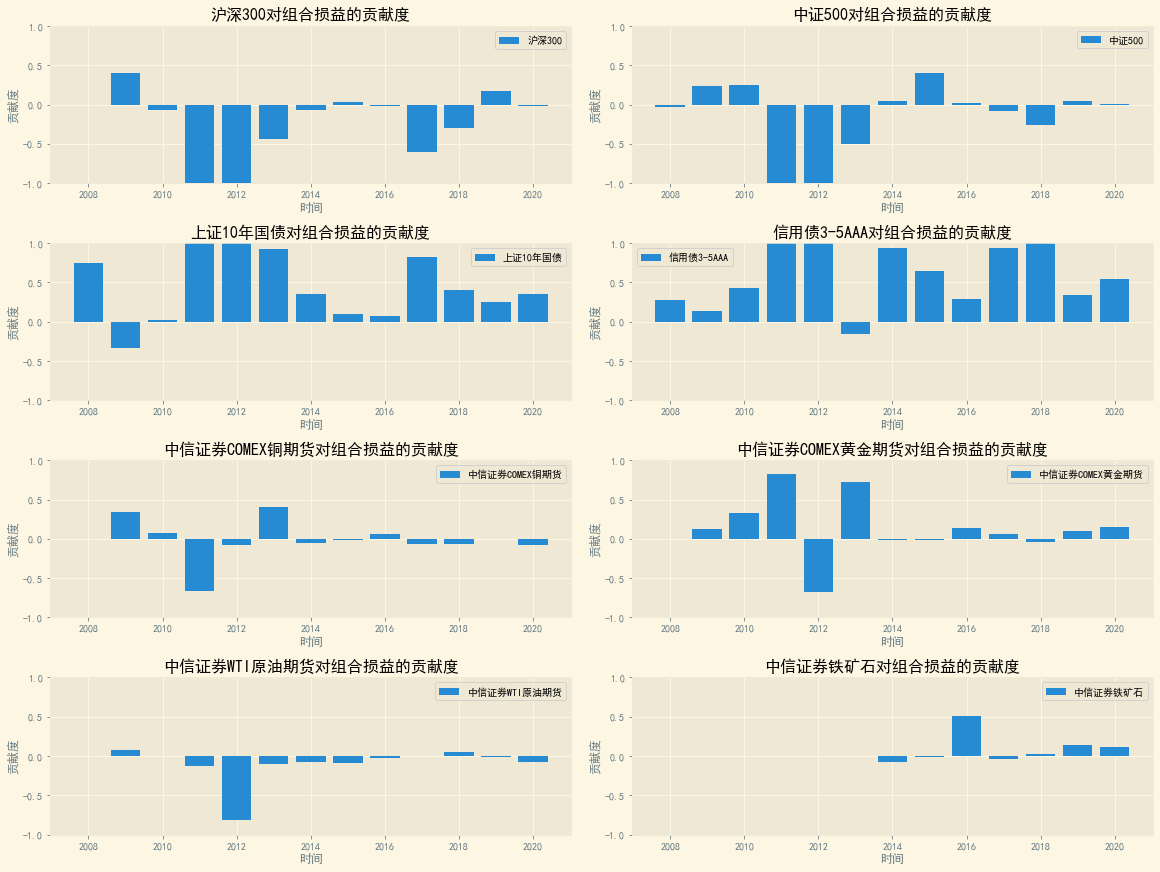

In [27]:
StatisticFunc.BarPlot(annualContrb_2, '横截面动量+换手率+铜金+铜油C')

### 投资组合净值曲线

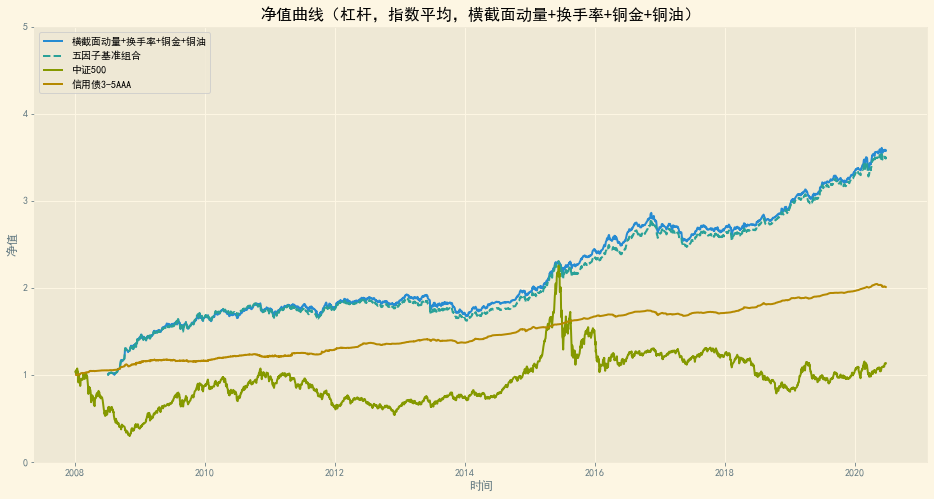

In [39]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_2.index, tradeDF_2['投资组合净值']/10000, label='横截面动量+换手率+铜金+铜油')
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+换手率+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+换手率+铜金+铜油）C.png')

## 横截面动量+时序动量+铜金+铜油

### 程序运行

In [28]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 
            'copperGold':True, 'copperGas':True}

tradeDF_3, weightDF_3 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

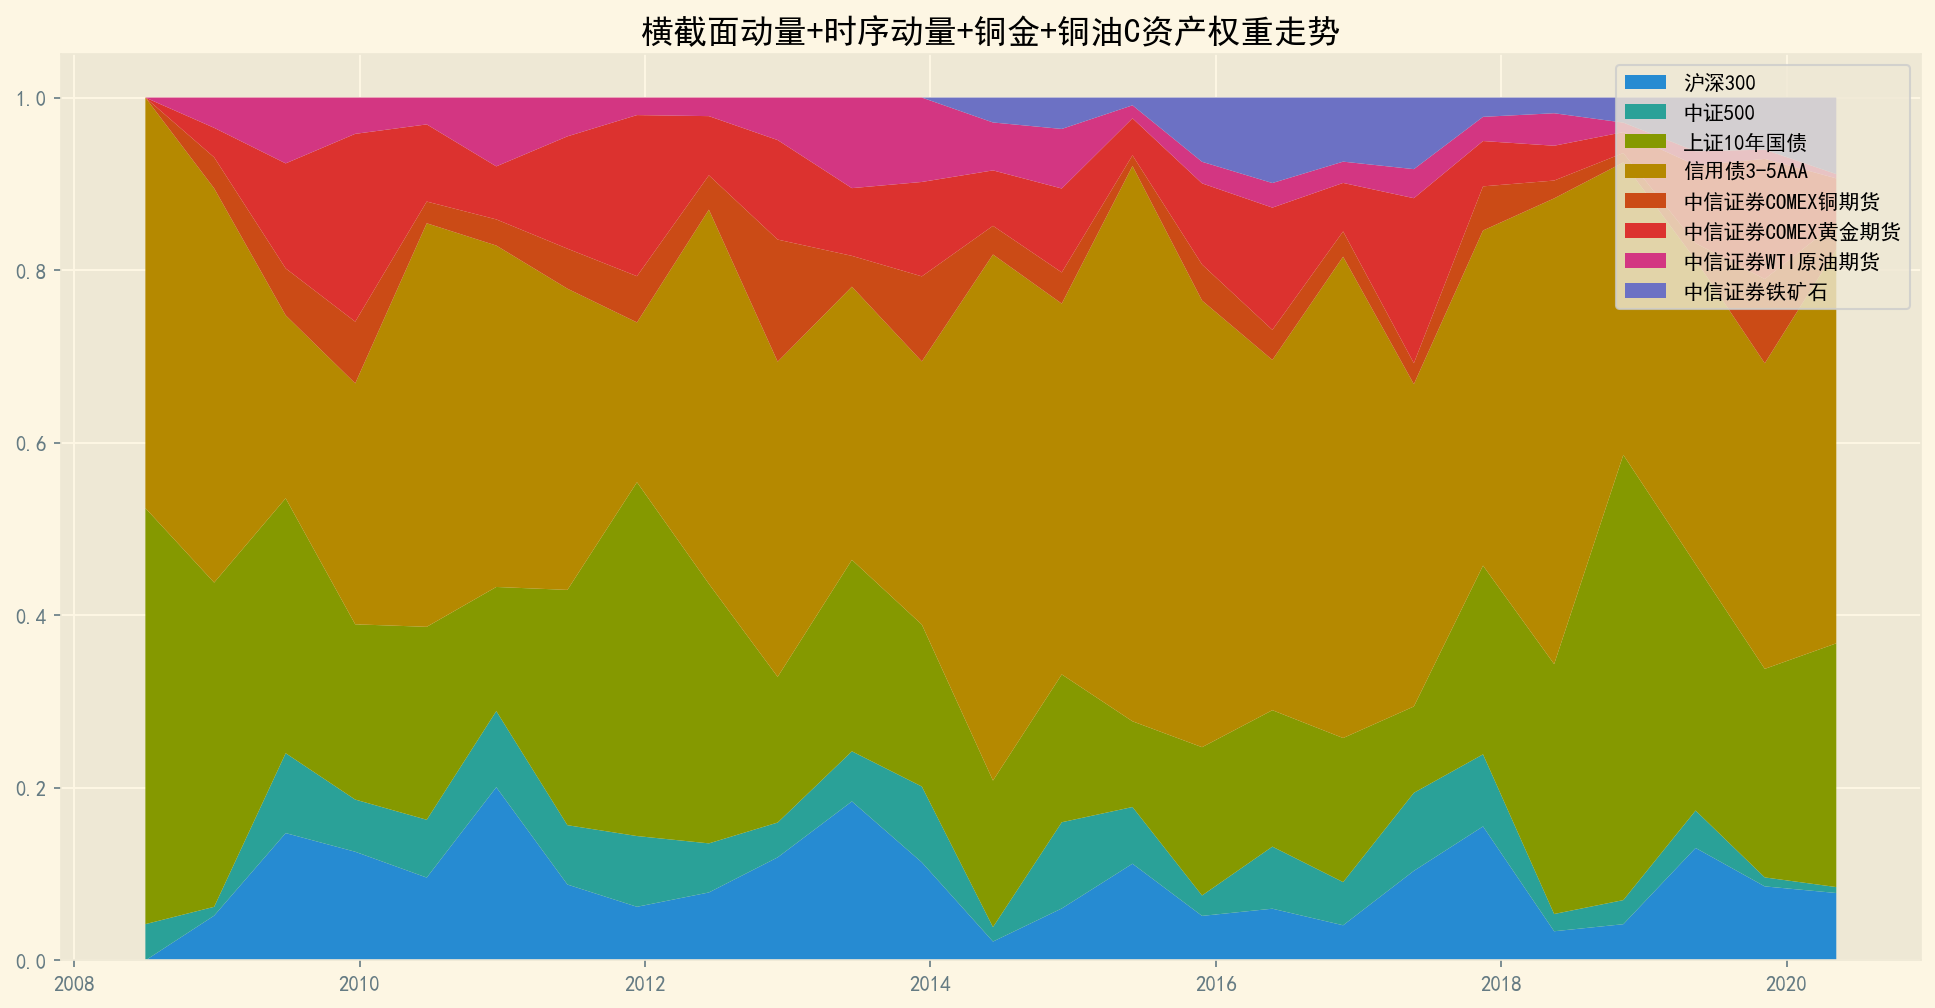

In [41]:
StatisticFunc.WeightPlot(tradeDF_3, weightDF_3, '横截面动量+时序动量+铜金+铜油C')

### 回测表现汇总

In [42]:
# 表现汇总
years = np.unique(tradeDF_3.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_3 = pd.DataFrame(index=years)

SummaryDF_3["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_3['投资组合净值']) )
SummaryDF_3["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_3['投资组合净值'])).values
SummaryDF_3["无基准夏普比率"] = SummaryDF_3['年收益率'] / SummaryDF_3['年波动率']
SummaryDF_3["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_3['最大回撤'])).values

SummaryDF_3

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.425407,0.147482,2.88447,-0.032915
2009,0.136758,0.109611,1.24767,-0.066562
2010,0.0557214,0.079981,0.696681,-0.059190
2011,0.0212942,0.085973,0.247685,-0.084512
2012,0.0399943,0.052926,0.755661,-0.045656
2013,-0.0967777,0.075506,-1.28172,-0.133515
2014,0.148155,0.049700,2.98102,-0.140931
2015,0.241328,0.071177,3.39055,-0.052047
2016,0.114437,0.059587,1.92051,-0.078262
2017,-0.0130989,0.046535,-0.281487,-0.117724


### 收益率贡献度

In [29]:
annualContrb_3 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_3, weightDF=weightDF_3, assetDF=leverCumReturns)

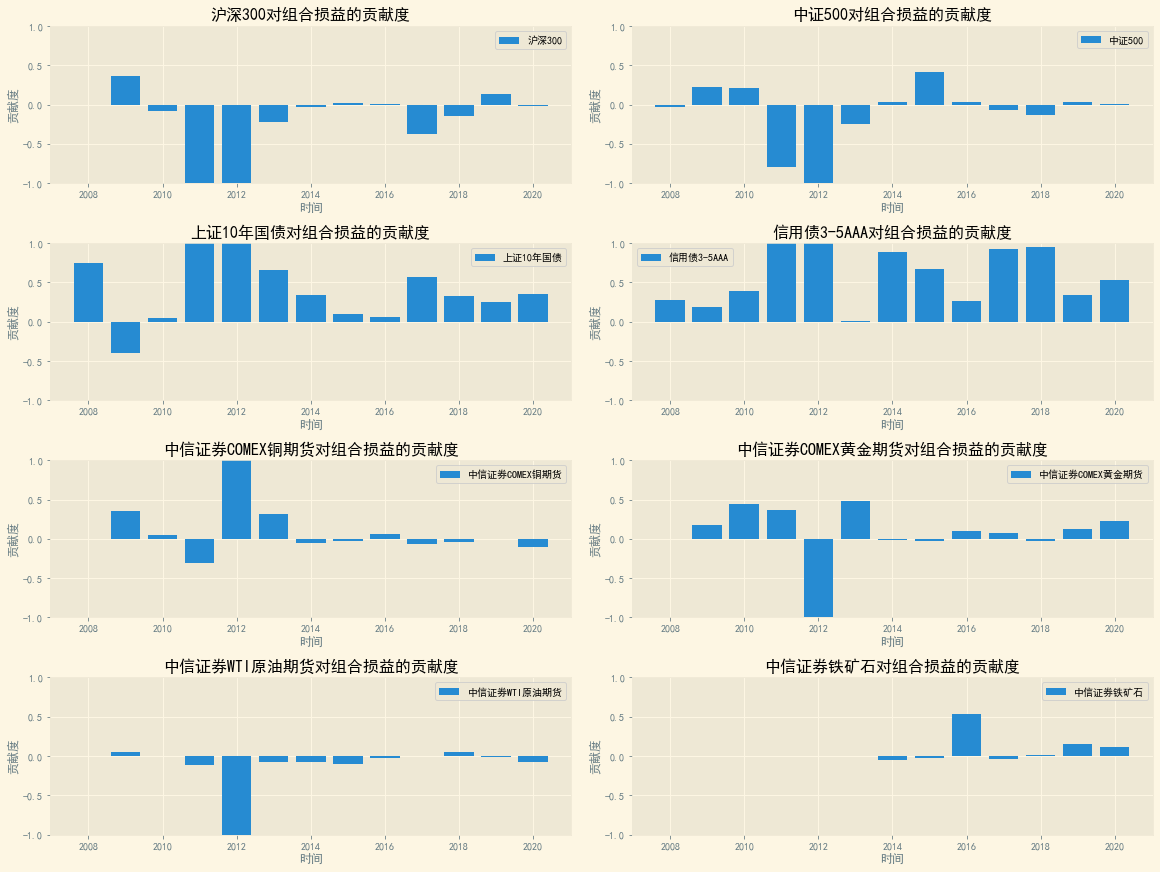

In [30]:
StatisticFunc.BarPlot(annualContrb_3, '横截面动量+时序动量+铜金+铜油C')

### 投资组合净值曲线

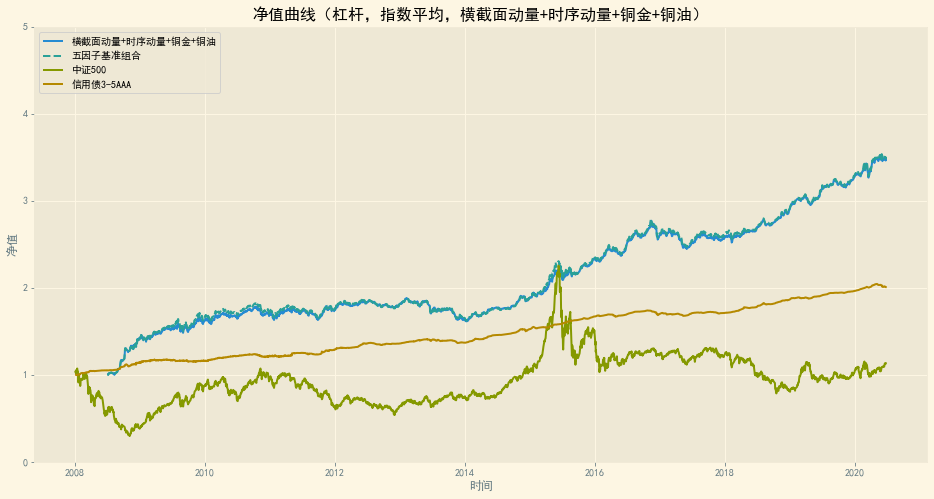

In [45]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_3.index, tradeDF_3['投资组合净值']/10000, label='横截面动量+时序动量+铜金+铜油')
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+时序动量+铜金+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+时序动量+铜金+铜油）C.png')

## 横截面动量+时序动量+换手率+铜油

### 程序运行

In [31]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':False, 'copperGas':True}

tradeDF_4, weightDF_4 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

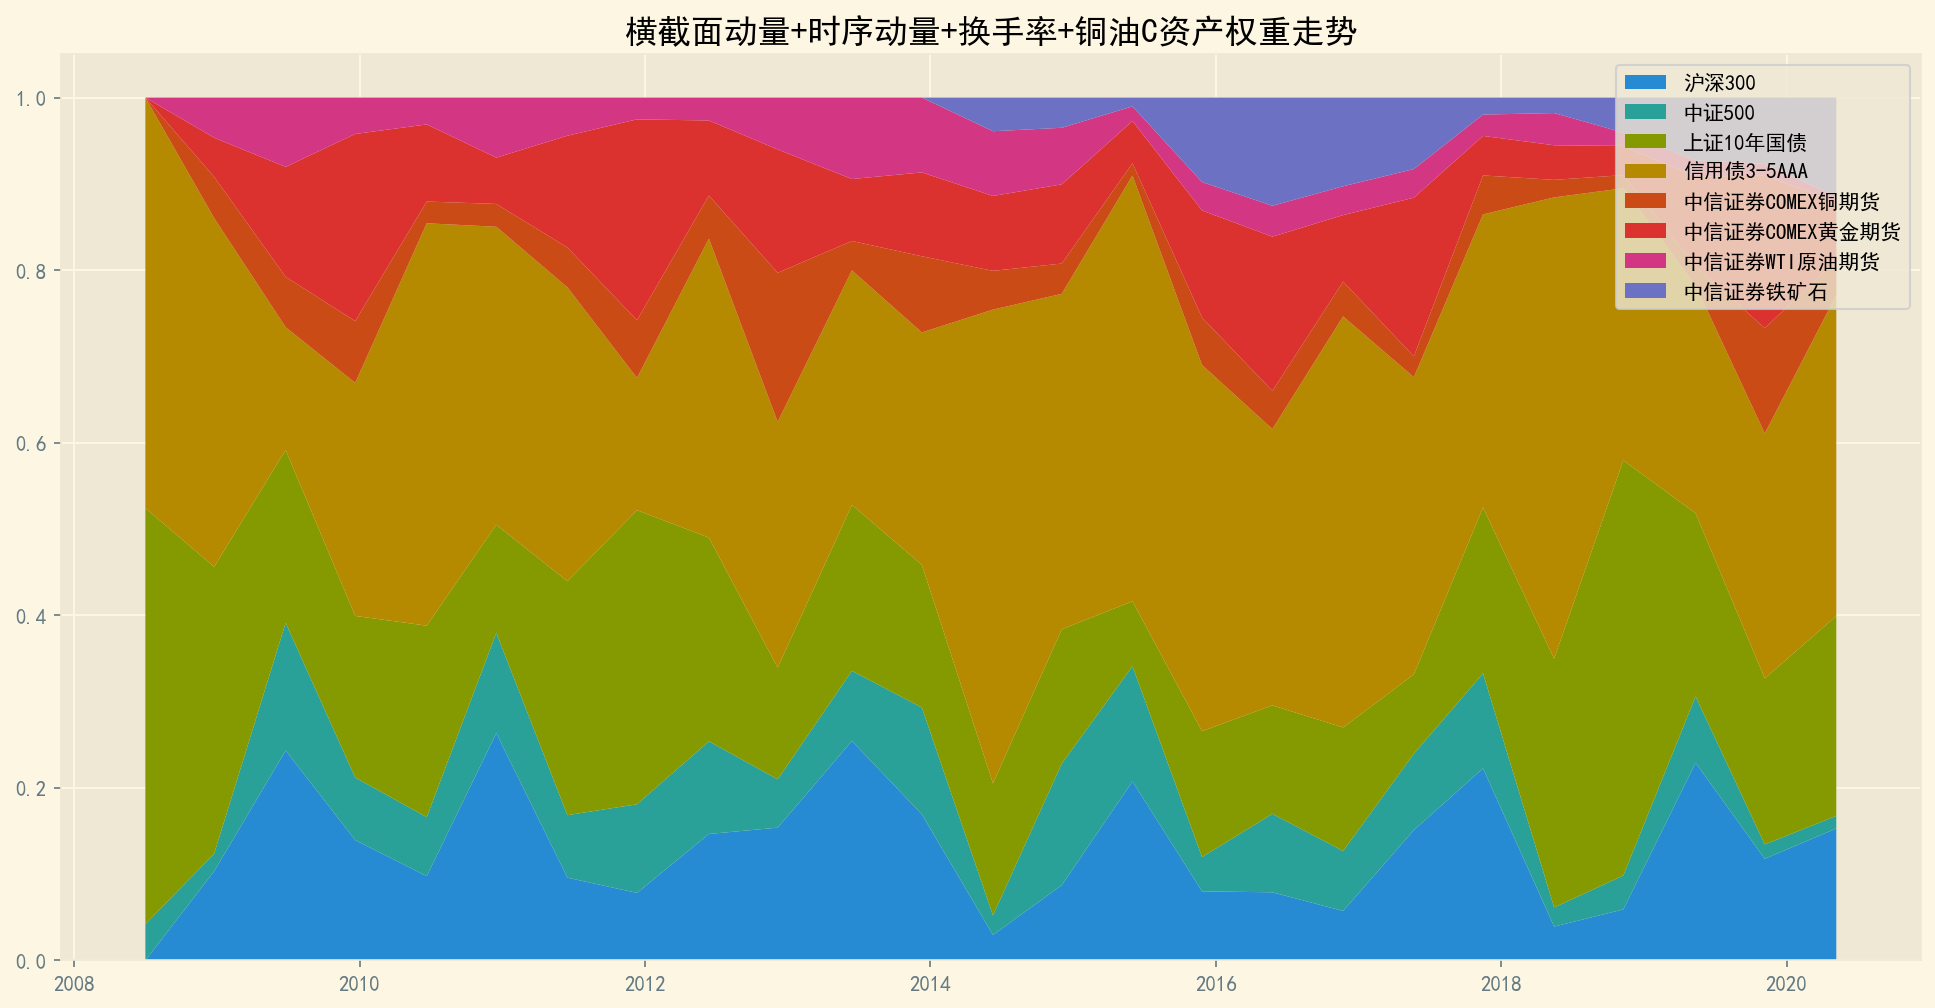

In [47]:
StatisticFunc.WeightPlot(tradeDF_4, weightDF_4, '横截面动量+时序动量+换手率+铜油C')

### 回测表现汇总

In [48]:
# 表现汇总
years = np.unique(tradeDF_4.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_4 = pd.DataFrame(index=years)

SummaryDF_4["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_4['投资组合净值']) )
SummaryDF_4["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_4['投资组合净值'])).values
SummaryDF_4["无基准夏普比率"] = SummaryDF_4['年收益率'] / SummaryDF_4['年波动率']
SummaryDF_4["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_4['最大回撤'])).values

SummaryDF_4

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.428982,0.147783,2.90278,-0.032915
2009,0.227357,0.141074,1.61161,-0.104743
2010,0.0446377,0.082462,0.541311,-0.064315
2011,0.00172979,0.090974,0.0190141,-0.096247
2012,0.0275897,0.067021,0.411658,-0.070429
2013,-0.102942,0.089635,-1.14846,-0.143804
2014,0.12354,0.055051,2.24409,-0.153757
2015,0.206218,0.113776,1.81248,-0.122686
2016,0.140371,0.072219,1.94367,-0.074165
2017,-0.000430005,0.053277,-0.00807109,-0.109936


### 收益率贡献度

In [32]:
annualContrb_4 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_4, weightDF=weightDF_4, assetDF=leverCumReturns)

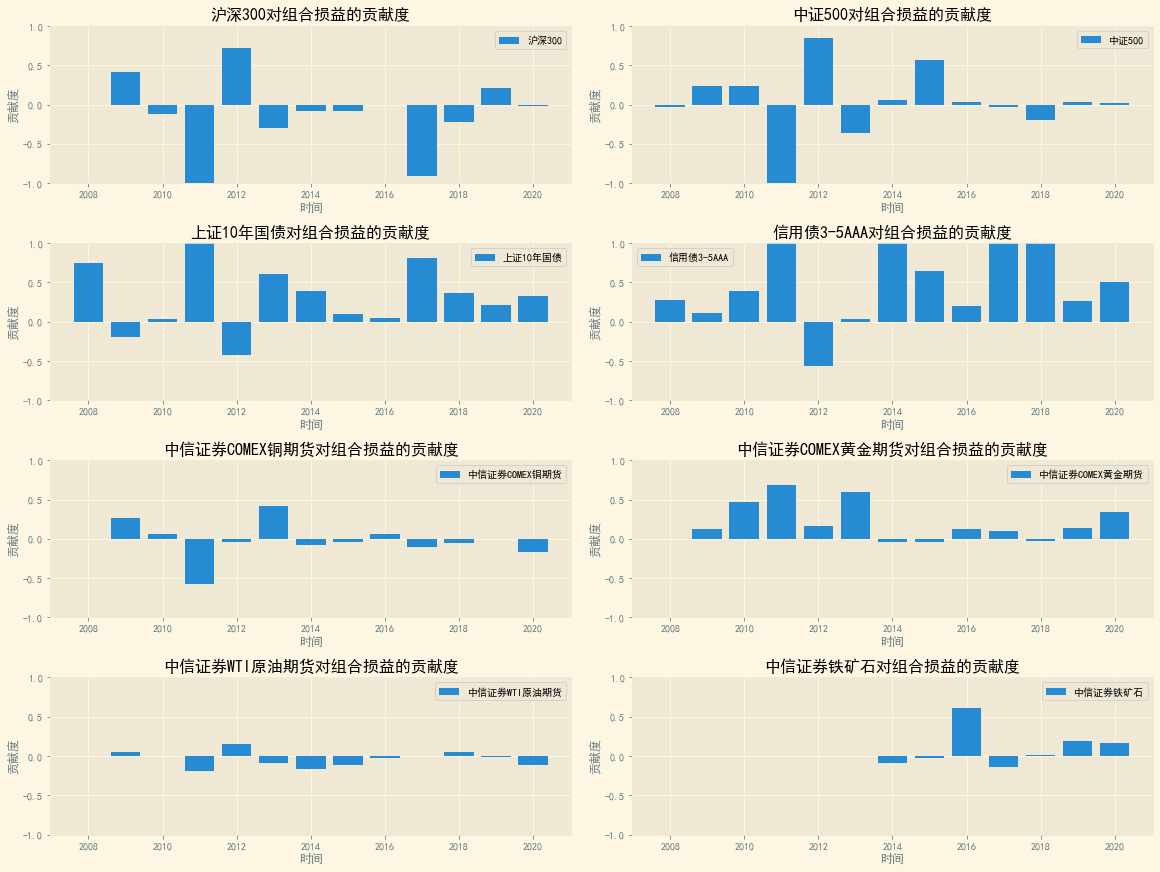

In [33]:
StatisticFunc.BarPlot(annualContrb_4, '横截面动量+时序动量+换手率+铜油C')

### 投资组合净值曲线

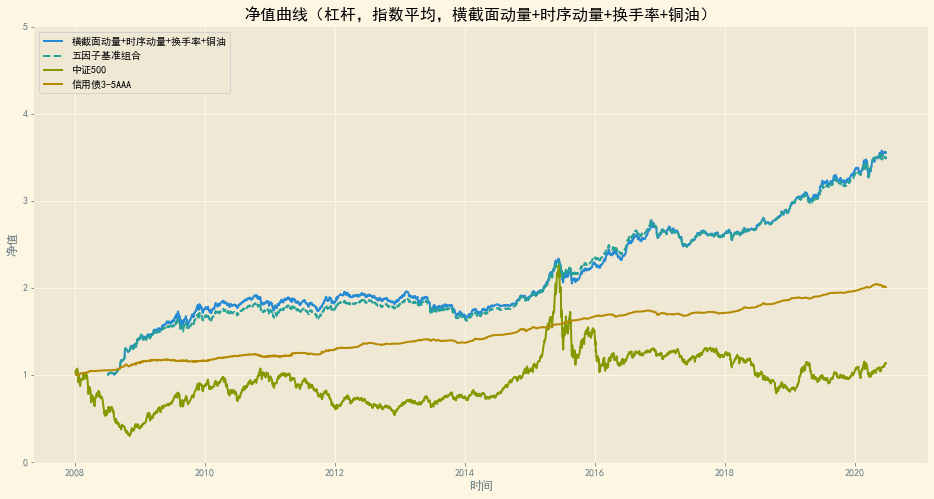

In [51]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_4.index, tradeDF_4['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜油')
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜油）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜油）C.png')

## 横截面动量+时序动量+换手率+铜金

### 程序运行

In [34]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 
            'copperGold':True, 'copperGas':False}

tradeDF_5, weightDF_5 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, mode='ema', 
                                       dt=120, up=0.50, thresholds=thrds, factorDict=factors)

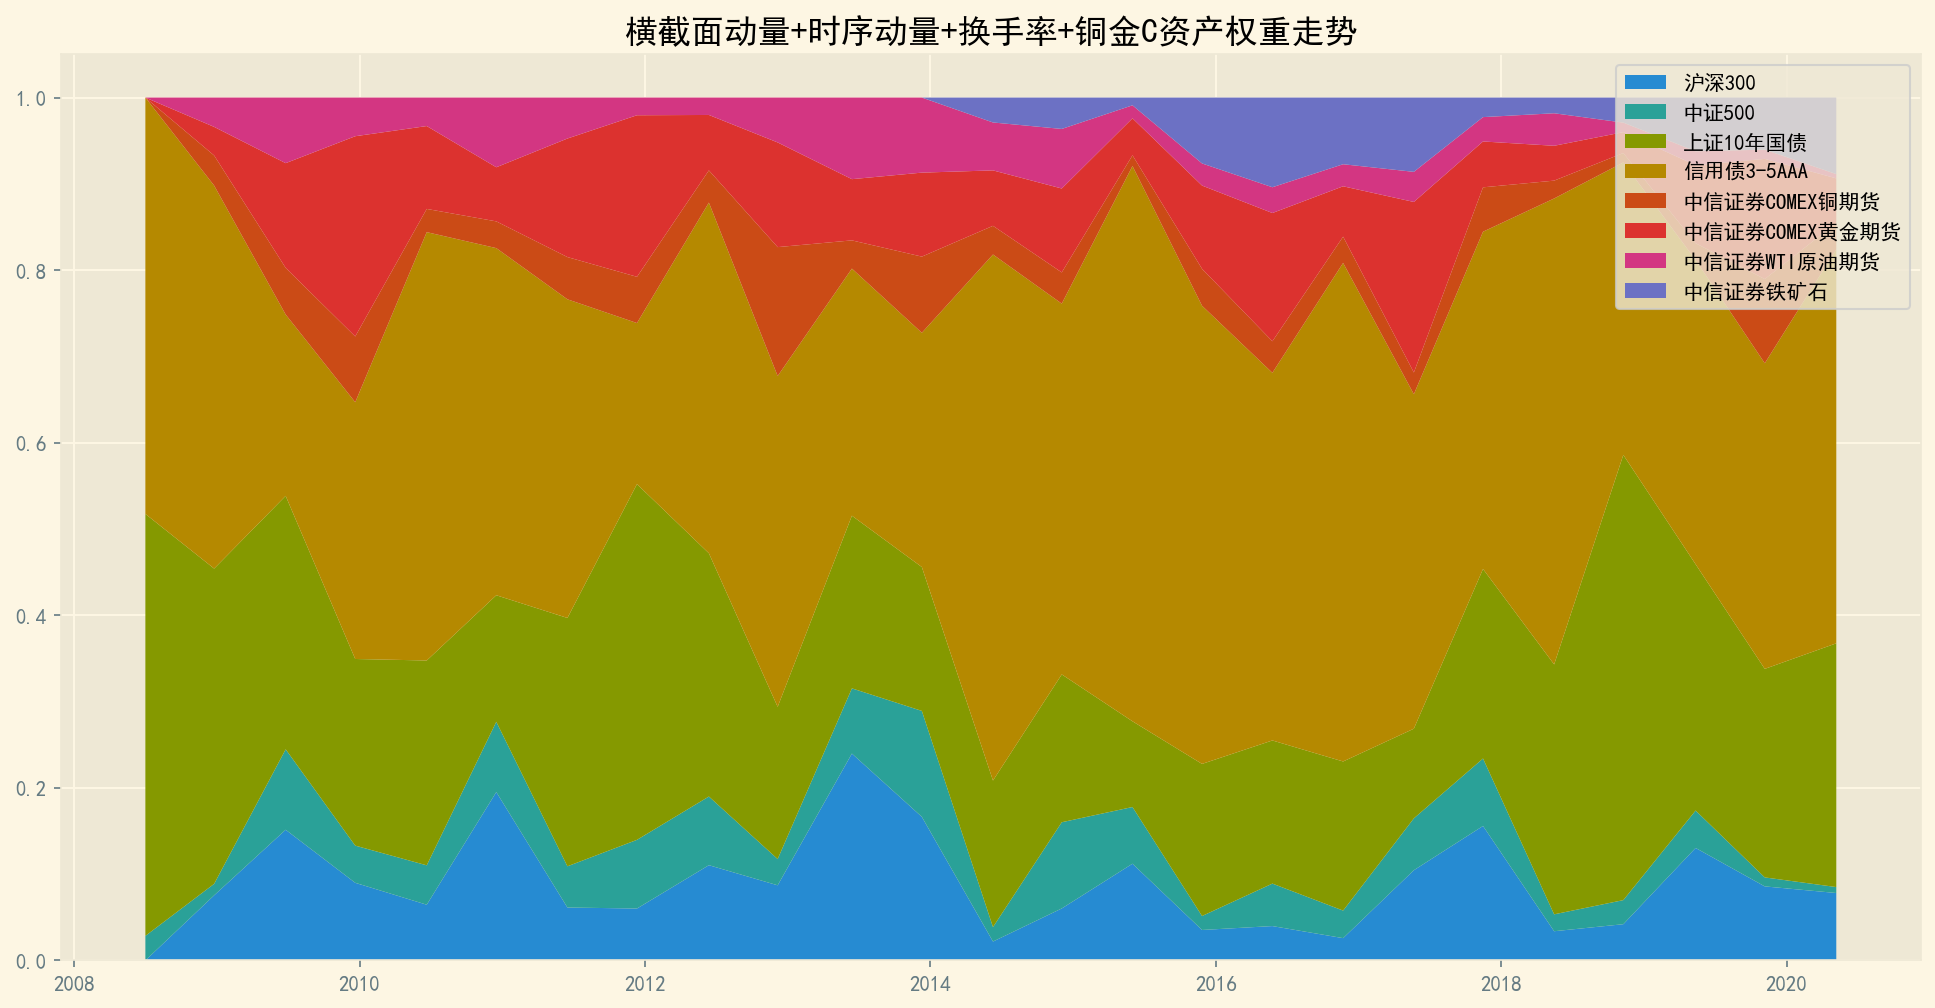

In [53]:
StatisticFunc.WeightPlot(tradeDF_5, weightDF_5, '横截面动量+时序动量+换手率+铜金C')

### 回测表现汇总

In [54]:
# 表现汇总
years = np.unique(tradeDF_5.reset_index()['日期'].apply(lambda x:str(x)[:4])) 

SummaryDF_5 = pd.DataFrame(index=years)

SummaryDF_5["年收益率"] = StatisticFunc.AnnualReturns( pd.DataFrame(tradeDF_5['投资组合净值']) )
SummaryDF_5["年波动率"] = StatisticFunc.AnnualVolatility(pd.DataFrame(tradeDF_5['投资组合净值'])).values
SummaryDF_5["无基准夏普比率"] = SummaryDF_5['年收益率'] / SummaryDF_5['年波动率']
SummaryDF_5["最大回撤"] = StatisticFunc.AnnualMaxDrawdown(pd.DataFrame(tradeDF_5['最大回撤'])).values

SummaryDF_5

,年收益率,年波动率,无基准夏普比率,最大回撤
2008,0.433497,0.148493,2.91931,-0.032252
2009,0.153513,0.110661,1.38723,-0.067768
2010,0.0597039,0.075854,0.787087,-0.064482
2011,0.0334523,0.085381,0.391801,-0.089193
2012,0.0245256,0.054369,0.4511,-0.052668
2013,-0.0889674,0.079354,-1.12115,-0.125596
2014,0.133738,0.053578,2.49612,-0.135637
2015,0.241126,0.071122,3.39031,-0.052047
2016,0.121253,0.059334,2.04357,-0.079517
2017,-0.0172658,0.046382,-0.372249,-0.118959


### 收益率贡献度

In [35]:
annualContrb_5 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_5, weightDF=weightDF_5, assetDF=leverCumReturns)

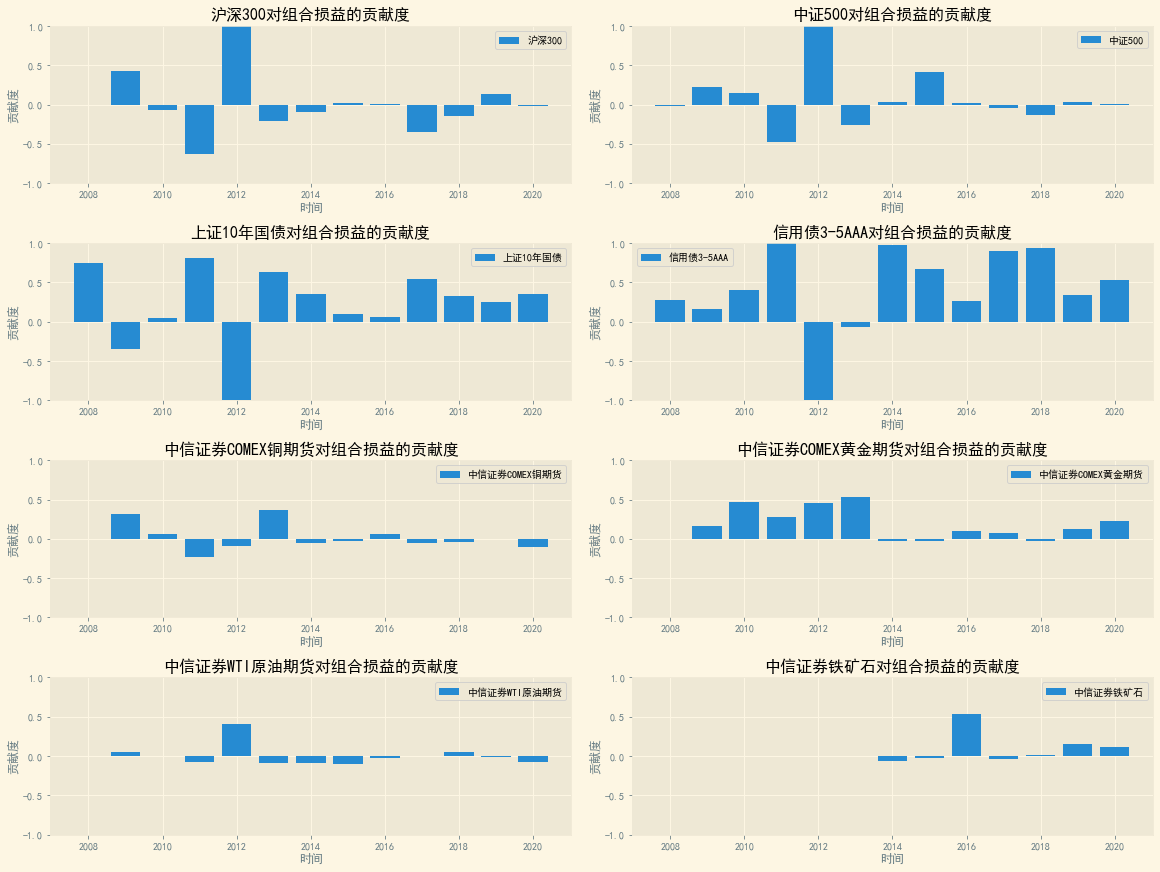

In [36]:
StatisticFunc.BarPlot(annualContrb_5, '横截面动量+时序动量+换手率+铜金C')

### 投资组合净值曲线

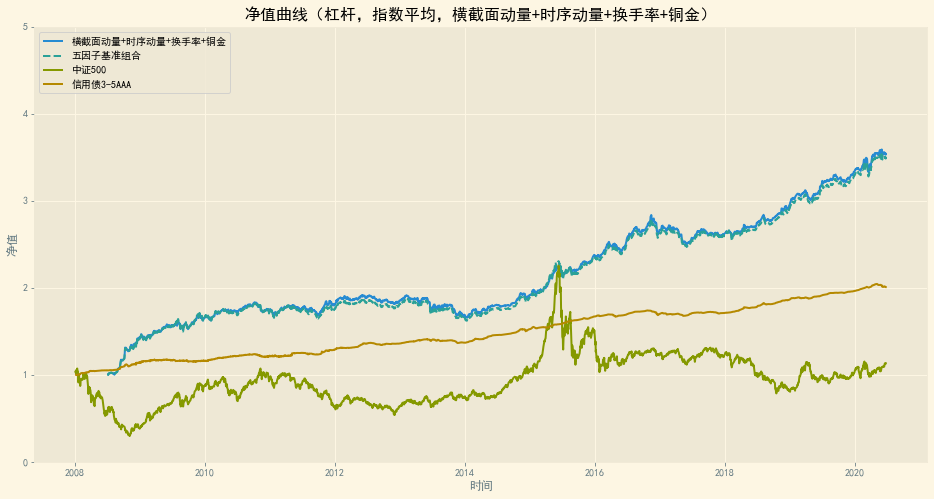

In [57]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_5.index, tradeDF_5['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金')
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='五因子基准组合')
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['信用债3-5AAA'], label='信用债3-5AAA')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 5.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜金）')
plt.savefig('净值曲线（杠杆，指数平均，横截面动量+时序动量+换手率+铜金）C.png')